In [4]:
from utils import read_MoGCN_data

# Data
path_1 = "data/fpkm_data.csv" # RNA-seq
path_2 = "data/gistic_data.csv" # CNV
path_3 = "data/rppa_data.csv" # RPPA
path_4 = "data/sample_classes.csv" # GT labels

omics_data = read_MoGCN_data([path_1, path_2, path_3])
gt_labels = read_MoGCN_data([path_4])[0]

for omics in omics_data:
    display(omics.head(1))

display(gt_labels.head(1))

,Sample,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,SLCO4C1,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4
0,A1-A0SF,2.067434,1.942403,3.560276,0.135735,7.743208,4.657533,1.223453,3.703006,2.805578,...,0.073609,2.762001,0.418301,3.851872,0.427608,0.094974,0.062719,4.067202,0.519763,0.0


,Sample,CDK11A,NADK,PRKCZ,GNB1,SDF4,DVL1,MORN1,INTS11,ACAP3,...,CTAG1A,H2AB1,F8A2,F8A3,F8A1,H2AB3,H2AB2,VAMP7,IL9R,SPRY3
0,A1-A0SF,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0


,Sample,1433EPSILON,4EBP1,4EBP1_pS65,4EBP1_pT37T46,53BP1,ACC_pS79,ACC1,AKT,AKT_pS473,...,CHK1_pS296,COG3,DUSP4,ERCC5,IGF1R_pY1135Y1136,IRF1,JAK2,P16INK4A,SHP2_pY542,PDL1
0,A1-A0SF,-0.14805,0.28069,-0.20683,0.043661,0.007723,0.73249,0.36581,0.20897,-0.045389,...,-0.07192,0.25539,-0.19709,-0.042783,0.1411,-0.2173,-0.25174,0.17445,0.46637,0.020988


,Sample,class,PAM50Call_RNAseq
0,A1-A0SF,0,LumA


In [7]:
import torch
from torch import nn, optim
from dataset import MoGCN_Dataset
from torch.utils.data import DataLoader
from utils import setup_seed
import gc

setup_seed(42)

def train_test(omics_data, gt_labels, model, num_epochs=100, path_train_samples="data/train_samples.csv", path_test_samples="data/test_samples.csv"):

    DEVICE = torch.device("cpu")
    
    # Config
    if torch.cuda.is_available():
        # Clear CUDA
        torch.cuda.empty_cache()
        gc.collect()
        DEVICE = torch.device("cuda")
    
    batch_size = 32
    lr_rate = 0.001

    # Train dataset
    MoGCN_train = MoGCN_Dataset(omics_data, gt_labels, path_train_samples)
    train_loader = DataLoader(
        MoGCN_train,
        batch_size=batch_size,
        shuffle=True
    )

    # Test dataset
    MoGCN_test = MoGCN_Dataset(omics_data, gt_labels, path_test_samples)
    test_loader = DataLoader(
        MoGCN_test,
        batch_size=batch_size,
        shuffle=True
    )

    # Model
    model = model(MoGCN_train.input_dims)
    optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.MSELoss()

    # Train
    model.to(DEVICE)
    model.train()
    model.train_loop(train_loader, optimizer, loss_fn, num_epochs)

    #Test
    model.eval()  # before save and test, fix the variables
    model.test(test_loader, loss_fn)
    torch.save(model, f"model/AE/{model}_model.pkl")

epoch: 1 | loss: 39.6306
epoch: 2 | loss: 26.5460
epoch: 3 | loss: 18.2081
epoch: 4 | loss: 12.7795
epoch: 5 | loss: 9.3329
epoch: 6 | loss: 7.1641
epoch: 7 | loss: 5.8223
epoch: 8 | loss: 4.9746
epoch: 9 | loss: 4.4474
epoch: 10 | loss: 4.1042
epoch: 11 | loss: 3.8831
epoch: 12 | loss: 3.7399
epoch: 13 | loss: 3.6323
epoch: 14 | loss: 3.5677
epoch: 15 | loss: 3.5133
epoch: 16 | loss: 3.4637
epoch: 17 | loss: 3.4193
epoch: 18 | loss: 3.3857
epoch: 19 | loss: 3.3459
epoch: 20 | loss: 3.3138
epoch: 21 | loss: 3.2825
epoch: 22 | loss: 3.2554
epoch: 23 | loss: 3.2271
epoch: 24 | loss: 3.1967
epoch: 25 | loss: 3.1618
epoch: 26 | loss: 3.1402
epoch: 27 | loss: 3.1090
epoch: 28 | loss: 3.0803
epoch: 29 | loss: 3.0487
epoch: 30 | loss: 3.0266
epoch: 31 | loss: 3.0041
epoch: 32 | loss: 2.9743
epoch: 33 | loss: 2.9599
epoch: 34 | loss: 2.9441
epoch: 35 | loss: 2.9266
epoch: 36 | loss: 2.8952
epoch: 37 | loss: 2.8738
epoch: 38 | loss: 2.8537
epoch: 39 | loss: 2.8297
epoch: 40 | loss: 2.8214
epoch

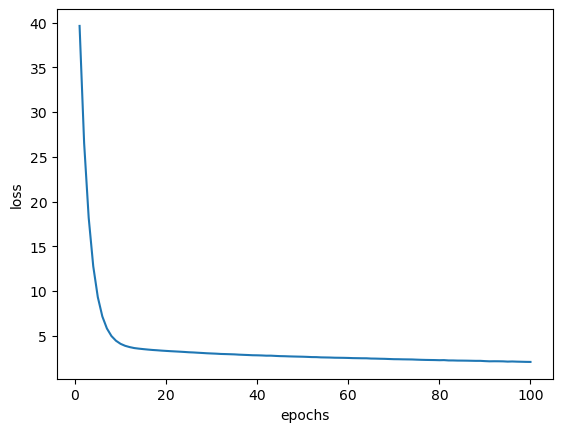

In [8]:
from models import MMAE

train_test(omics_data, gt_labels, MMAE, num_epochs=100)